In [1]:
import nanomotif as nm
import polars as pl
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def plot_search_graph(graph, label_mean_min = 0.3):
    pos = nx.kamada_kawai_layout(graph)
    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.5}
    node_colors = [graph.nodes[i]["model"].mean() for i in graph.nodes]
    nodes = nx.draw_networkx_nodes(graph, pos, node_size=50, node_color=node_colors, cmap=plt.cm.cividis_r, alpha=1, margins=0.0)
    nx.draw_networkx_edges(graph, pos, width=0.2, alpha=1);

    stripped_labels = {i: i.rstrip(".").lstrip(".") for i in graph.nodes if graph.nodes[i]["model"].mean() > label_mean_min}
    nx.draw_networkx_labels(graph, pos, stripped_labels, font_size=10, font_color="black");
    plt.colorbar(nodes)

def nxgraph_to_dataframe(graph):
    return pl.DataFrame({
        "sequence":[i for i in graph.nodes],
        "model":[graph.nodes[i]["model"] for i in graph.nodes],
        "mean":[graph.nodes[i]["model"].mean() for i in graph.nodes]
    }).sort("mean", descending=True)

In [3]:
assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ecoli = nm.load_pileup("../data/ecoli/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_3") \
    .filter(pl.col("mod_type") == "m") \
    .filter(pl.col("Nvalid_cov") > 5) \
    .filter(pl.col("fraction_mod") > 0.8) 

In [4]:
sequence = assembly.assembly["contig_3"]
padding = 10
methylation_index_fwd = ecoli \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = ecoli \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences = methylation_sequences_fwd + methylation_sequences_rev

In [5]:
astar_test = nm.evaluate.a_star_search(".....................", sequence, ecoli, methylation_sequences, min_kl = 0.1, extra_rounds = 3)

DEBUG: ..................... | BetaBernoulliModel(alpha=24742, beta=9255598) 
DEBUG: ..........C.......... | BetaBernoulliModel(alpha=24572, beta=2332182) 
DEBUG: .........C........... | BetaBernoulliModel(alpha=24320, beta=2332434) 
DEBUG: ............G........ | BetaBernoulliModel(alpha=24210, beta=2332544) 
DEBUG: .............G....... | BetaBernoulliModel(alpha=24175, beta=2332579) 
DEBUG: ..........C.G........ | BetaBernoulliModel(alpha=24090, beta=690606) 
DEBUG: ..........C.GG....... | BetaBernoulliModel(alpha=24017, beta=165187) 
DEBUG: .........CC.G........ | BetaBernoulliModel(alpha=23967, beta=165237) 
DEBUG: .........CC.GG....... | BetaBernoulliModel(alpha=23953, beta=18093) 


In [6]:
nxgraph_to_dataframe(astar_test)

sequence,model,mean
str,object,f64
""".........CCTGG…","BetaBernoulliModel(alpha=11995, beta=54)",0.995518
""".........CCAGG…","BetaBernoulliModel(alpha=11959, beta=90)",0.992531
""".........CC.GG…","BetaBernoulliModel(alpha=23953, beta=18093)",0.569686
""".........CCTG.…","BetaBernoulliModel(alpha=12008, beta=37449)",0.242797
"""..........CAGG…","BetaBernoulliModel(alpha=11990, beta=37467)",0.242433
"""..........CTGG…","BetaBernoulliModel(alpha=12022, beta=56007)",0.176719
""".........CCAG.…","BetaBernoulliModel(alpha=11960, beta=56069)",0.175807
"""..........C.GG…","BetaBernoulliModel(alpha=24017, beta=165187)",0.126937
""".........CC.G.…","BetaBernoulliModel(alpha=23967, beta=165237)",0.126673


DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='ita

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f3c8fb8c6d0>


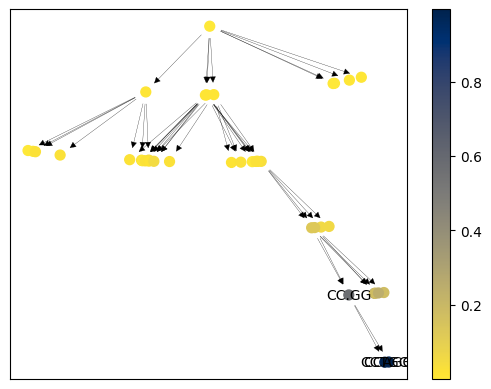

In [7]:
plot_search_graph(astar_test)

In [8]:
assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
geobacillus = nm.load_pileup("../data/geobacillus/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_3") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 5) \
    .filter(pl.col("fraction_mod") > 0.85) 

In [9]:
sequence = assembly.assembly["contig_3"]
padding = 10
methylation_index_fwd = geobacillus \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = geobacillus \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_iter1 = methylation_sequences_fwd + methylation_sequences_rev

In [10]:
search_iter1 = nm.evaluate.a_star_search("." * (padding*2 + 1), sequence, geobacillus, methylation_sequences_iter1, min_kl = 0.1, extra_rounds = 2)

DEBUG: ..................... | BetaBernoulliModel(alpha=700, beta=165134) 
DEBUG: ..........A.......... | BetaBernoulliModel(alpha=678, beta=46016) 
DEBUG: ...........T......... | BetaBernoulliModel(alpha=598, beta=46096) 
DEBUG: ............C........ | BetaBernoulliModel(alpha=590, beta=35635) 
DEBUG: .........G........... | BetaBernoulliModel(alpha=515, beta=35710) 
DEBUG: ..........AT......... | BetaBernoulliModel(alpha=596, beta=13268) 
DEBUG: ..........A.C........ | BetaBernoulliModel(alpha=580, beta=8847) 
DEBUG: ...........TC........ | BetaBernoulliModel(alpha=536, beta=9923) 
DEBUG: .........GA.......... | BetaBernoulliModel(alpha=513, beta=9946) 


DEBUG: .........G.T......... | BetaBernoulliModel(alpha=513, beta=8914) 
DEBUG: ..........ATC........ | BetaBernoulliModel(alpha=535, beta=2688) 
DEBUG: .........G..C........ | BetaBernoulliModel(alpha=513, beta=6091) 


In [11]:
nxgraph_to_dataframe(search_iter1)

sequence,model,mean
str,object,f64
""".........GATC.…","BetaBernoulliModel(alpha=513, beta=197)",0.722535
""".........GA.C.…","BetaBernoulliModel(alpha=513, beta=1544)",0.249392
""".........G.TC.…","BetaBernoulliModel(alpha=513, beta=1544)",0.249392
"""..........ATC.…","BetaBernoulliModel(alpha=535, beta=2688)",0.165994
""".........GAT..…","BetaBernoulliModel(alpha=513, beta=2710)",0.159168
"""........CG..C.…","BetaBernoulliModel(alpha=174, beta=1668)",0.094463
"""........TG..C.…","BetaBernoulliModel(alpha=166, beta=1879)",0.081174
""".........G..C.…","BetaBernoulliModel(alpha=513, beta=6091)",0.07768
"""........CGA...…","BetaBernoulliModel(alpha=179, beta=2337)",0.071145


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f3cc1b099a0>


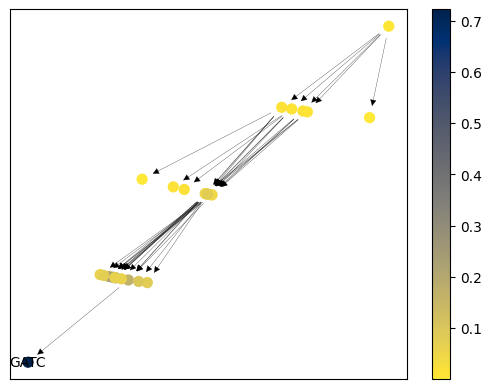

In [12]:
plot_search_graph(search_iter1)

In [16]:
methylation_sequences_iter2 = methylation_sequences_iter1.get_sequences_without_match(".........GATC........")
search_iter2 = nm.evaluate.a_star_search("." * (padding*2 + 1), sequence, geobacillus, methylation_sequences_iter2, min_kl = 0.1, extra_rounds = 2)

DEBUG: ..................... | BetaBernoulliModel(alpha=700, beta=165134) 
DEBUG: ..........A.......... | BetaBernoulliModel(alpha=678, beta=46016) 
DEBUG: ...........T......... | BetaBernoulliModel(alpha=598, beta=46096) 
DEBUG: ............C........ | BetaBernoulliModel(alpha=590, beta=35635) 
DEBUG: ..........AT......... | BetaBernoulliModel(alpha=596, beta=13268) 
DEBUG: ..........A.C........ | BetaBernoulliModel(alpha=580, beta=8847) 
DEBUG: ...........TC........ | BetaBernoulliModel(alpha=536, beta=9923) 
DEBUG: ..........ATC........ | BetaBernoulliModel(alpha=535, beta=2688) 
DEBUG: ......A.............. | BetaBernoulliModel(alpha=210, beta=46484) 
DEBUG: .......C............. | BetaBernoulliModel(alpha=231, beta=35994) 
DEBUG: ........C............ | BetaBernoulliModel(alpha=225, beta=36000) 
DEBUG: ......C.............. | BetaBernoulliModel(alpha=206, beta=36019) 
DEBUG: .....G............... | BetaBernoulliModel(alpha=190, beta=36035) 
DEBUG: .........A........... | BetaBerno

In [17]:
nxgraph_to_dataframe(search_iter2)

sequence,model,mean
str,object,f64
"""......CCAAAT..…","BetaBernoulliModel(alpha=66, beta=16)",0.804878
"""...T..CCA.AT..…","BetaBernoulliModel(alpha=31, beta=39)",0.442857
"""...A..CCA.AT..…","BetaBernoulliModel(alpha=23, beta=39)",0.370968
"""......CCA.AT..…","BetaBernoulliModel(alpha=68, beta=131)",0.341709
"""......CC.AAT..…","BetaBernoulliModel(alpha=66, beta=140)",0.320388
"""........C.ATC.…","BetaBernoulliModel(alpha=67, beta=145)",0.316038
"""........C.ATC.…","BetaBernoulliModel(alpha=65, beta=157)",0.292793
"""........C.ATC.…","BetaBernoulliModel(alpha=49, beta=120)",0.289941
"""......CCAA.T..…","BetaBernoulliModel(alpha=66, beta=164)",0.286957


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f39c32e1fd0>


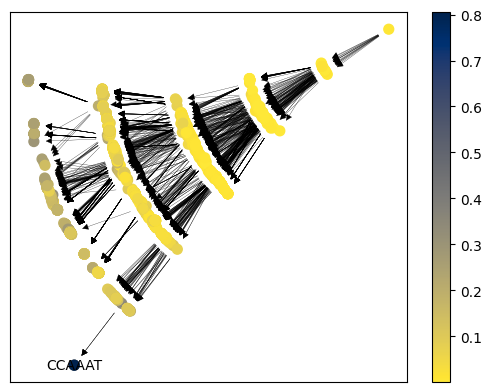

In [18]:
plot_search_graph(search_iter2, label_mean_min = 0.6)
# nodes

In [19]:
methylation_sequences_iter3 = methylation_sequences_iter2.get_sequences_without_match("......CCAAAT.........")
search_iter3 = nm.evaluate.a_star_search("." * (padding*2 + 1), sequence, geobacillus, methylation_sequences_iter3, min_kl = 0.1, extra_rounds = 2)

DEBUG: ..................... | BetaBernoulliModel(alpha=700, beta=165134) 
DEBUG: ..........A.......... | BetaBernoulliModel(alpha=678, beta=46016) 
DEBUG: ............C........ | BetaBernoulliModel(alpha=590, beta=35635) 
DEBUG: ..........A.C........ | BetaBernoulliModel(alpha=580, beta=8847) 
DEBUG: ......A.............. | BetaBernoulliModel(alpha=210, beta=46484) 
DEBUG: .......C............. | BetaBernoulliModel(alpha=231, beta=35994) 
DEBUG: ........C............ | BetaBernoulliModel(alpha=225, beta=36000) 
DEBUG: .....G............... | BetaBernoulliModel(alpha=190, beta=36035) 
DEBUG: ......G.............. | BetaBernoulliModel(alpha=184, beta=36041) 
DEBUG: .......G............. | BetaBernoulliModel(alpha=181, beta=36044) 
DEBUG: .........A........... | BetaBernoulliModel(alpha=136, beta=46558) 
DEBUG: ........G............ | BetaBernoulliModel(alpha=175, beta=36050) 
DEBUG: ........C.A.......... | BetaBernoulliModel(alpha=211, beta=8882) 
DEBUG: ............T........ | BetaBern

In [20]:
nxgraph_to_dataframe(search_iter3)

sequence,model,mean
str,object,f64
"""......ACCCA...…","BetaBernoulliModel(alpha=38, beta=29)",0.567164
"""........C.ATC.…","BetaBernoulliModel(alpha=30, beta=27)",0.526316
""".....G..GAAGT.…","BetaBernoulliModel(alpha=19, beta=18)",0.513514
""".....GA.GAAG..…","BetaBernoulliModel(alpha=39, beta=38)",0.506494
"""......A.C.ATC.…","BetaBernoulliModel(alpha=18, beta=18)",0.5
""".....G..GAAGC.…","BetaBernoulliModel(alpha=41, beta=48)",0.460674
"""........C.ATC.…","BetaBernoulliModel(alpha=23, beta=28)",0.45098
"""........C.ATCT…","BetaBernoulliModel(alpha=12, beta=15)",0.444444
"""........C.ATC.…","BetaBernoulliModel(alpha=27, beta=35)",0.435484


In [21]:
plot_search_graph(search_iter3, label_mean_min = 0.51)

KeyboardInterrupt: 

In [22]:
methylation_sequences_iter4 = methylation_sequences_iter3.get_sequences_without_match("......ACCCA..........")
search_iter4 = nm.evaluate.a_star_search("." * (padding*2 + 1), sequence, geobacillus, methylation_sequences_iter4, min_kl = 0.1, extra_rounds = 2)

DEBUG: ..................... | BetaBernoulliModel(alpha=700, beta=165134) 
DEBUG: ..........A.......... | BetaBernoulliModel(alpha=678, beta=46016) 
DEBUG: ............C........ | BetaBernoulliModel(alpha=590, beta=35635) 
DEBUG: ..........A.C........ | BetaBernoulliModel(alpha=580, beta=8847) 
DEBUG: ......A.............. | BetaBernoulliModel(alpha=210, beta=46484) 
DEBUG: .....G............... | BetaBernoulliModel(alpha=190, beta=36035) 
DEBUG: ......G.............. | BetaBernoulliModel(alpha=184, beta=36041) 
DEBUG: .........A........... | BetaBernoulliModel(alpha=136, beta=46558) 
DEBUG: ........G............ | BetaBernoulliModel(alpha=175, beta=36050) 
DEBUG: ...........G......... | BetaBernoulliModel(alpha=68, beta=36157) 
DEBUG: ........G.A.......... | BetaBernoulliModel(alpha=162, beta=9660) 
DEBUG: ......A...A.......... | BetaBernoulliModel(alpha=155, beta=8534) 
DEBUG: .....G....A.......... | BetaBernoulliModel(alpha=147, beta=7658) 
DEBUG: ........G...C........ | BetaBernoul

In [23]:
nxgraph_to_dataframe(search_iter4)

sequence,model,mean
str,object,f64
""".....GA.GAAGC.…","BetaBernoulliModel(alpha=28, beta=10)",0.736842
""".....GG.GAAGC.…","BetaBernoulliModel(alpha=14, beta=9)",0.608696
""".....G..GAAGT.…","BetaBernoulliModel(alpha=19, beta=18)",0.513514
""".....GA.GAAG..…","BetaBernoulliModel(alpha=39, beta=38)",0.506494
""".....G..GAAGC.…","BetaBernoulliModel(alpha=41, beta=48)",0.460674
""".....GA.G.AGC.…","BetaBernoulliModel(alpha=28, beta=35)",0.444444
""".....GA.GA.GC.…","BetaBernoulliModel(alpha=28, beta=50)",0.358974
""".....GA.GAA.C.…","BetaBernoulliModel(alpha=28, beta=56)",0.333333
""".....GG.GAAG..…","BetaBernoulliModel(alpha=20, beta=41)",0.327869


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f3929116af0>


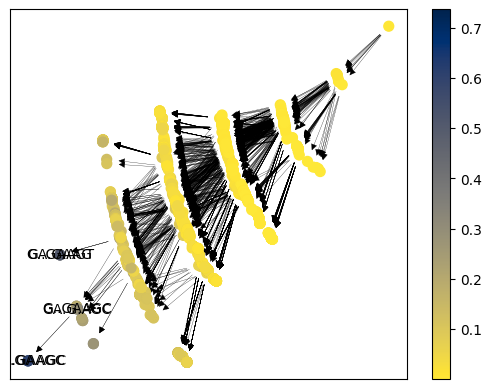

In [24]:
plot_search_graph(search_iter4, label_mean_min = 0.40)

In [25]:
methylation_sequences_iter5 = methylation_sequences_iter4.get_sequences_without_match(".....G[GA].GAAGC........")
search_iter5 = nm.evaluate.a_star_search("." * (padding*2 + 1), sequence, geobacillus, methylation_sequences_iter5, min_kl = 0.1, extra_rounds = 2)

DEBUG: ..................... | BetaBernoulliModel(alpha=700, beta=165134) 
DEBUG: ..........A.......... | BetaBernoulliModel(alpha=678, beta=46016) 
DEBUG: ............C........ | BetaBernoulliModel(alpha=590, beta=35635) 
DEBUG: ..........A.C........ | BetaBernoulliModel(alpha=580, beta=8847) 
DEBUG: ..........ATC........ | BetaBernoulliModel(alpha=535, beta=2688) 
DEBUG: ......A.............. | BetaBernoulliModel(alpha=210, beta=46484) 
DEBUG: ...T................. | BetaBernoulliModel(alpha=199, beta=46495) 
DEBUG: ...............T..... | BetaBernoulliModel(alpha=196, beta=46498) 
DEBUG: ...............C..... | BetaBernoulliModel(alpha=204, beta=36021) 
DEBUG: .....G............... | BetaBernoulliModel(alpha=190, beta=36035) 
DEBUG: ......G.............. | BetaBernoulliModel(alpha=184, beta=36041) 
DEBUG: ...G................. | BetaBernoulliModel(alpha=184, beta=36041) 
DEBUG: .......G............. | BetaBernoulliModel(alpha=181, beta=36044) 
DEBUG: .........A........... | BetaBern

KeyboardInterrupt: 

In [297]:
nxgraph_to_dataframe(search_iter5)

sequence,model,mean
str,object,f64
""".........GATC.…","BetaBernoulliModel(alpha=164, beta=36)",0.82
""".......G.GATC.…","BetaBernoulliModel(alpha=148, beta=37)",0.8
"""...C.....GATC.…","BetaBernoulliModel(alpha=153, beta=40)",0.792746
"""........CGATC.…","BetaBernoulliModel(alpha=179, beta=49)",0.785088
"""...G.....GATC.…","BetaBernoulliModel(alpha=135, beta=40)",0.771429
""".......C.GATC.…","BetaBernoulliModel(alpha=119, beta=36)",0.767742
""".........GATC.…","BetaBernoulliModel(alpha=148, beta=45)",0.766839
"""......C..GATC.…","BetaBernoulliModel(alpha=137, beta=42)",0.765363
"""G........GATC.…","BetaBernoulliModel(alpha=133, beta=41)",0.764368


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fbfbc6db430>


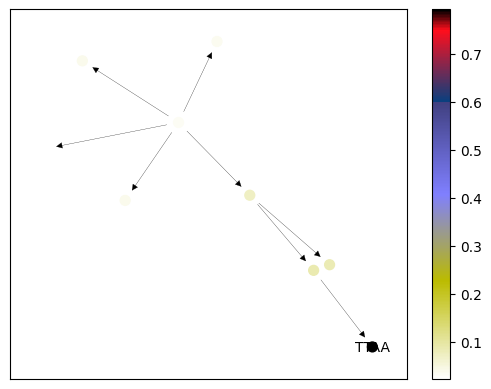

In [376]:
plot_search_graph(search_iter5, label_mean_min = 0.75)

In [299]:
methylation_sequences_iter6 = methylation_sequences_iter5.get_sequences_without_match(".....GA.GAAGT........")
search_iter6 = nm.evaluate.a_star_search("." * (padding*2 + 1), sequence, geobacillus, methylation_sequences_iter6, min_kl = 0.05, extra_rounds = 2)

DEBUG: ..................... | BetaBernoulliModel(alpha=700, beta=165134) 
DEBUG: ..........A.......... | BetaBernoulliModel(alpha=678, beta=46016) 
DEBUG: ..........A.C........ | BetaBernoulliModel(alpha=580, beta=8847) 
DEBUG: ..........AT......... | BetaBernoulliModel(alpha=596, beta=13268) 
DEBUG: ..........ATC........ | BetaBernoulliModel(alpha=535, beta=2688) 
DEBUG: .........GATC........ | BetaBernoulliModel(alpha=513, beta=197) 
DEBUG: .........GA.C........ | BetaBernoulliModel(alpha=513, beta=1544) 
DEBUG: .........GAT......... | BetaBernoulliModel(alpha=513, beta=2710) 
DEBUG: .........GA.......... | BetaBernoulliModel(alpha=513, beta=9946) 
DEBUG: ............C........ | BetaBernoulliModel(alpha=590, beta=35635) 
DEBUG: ...........TC........ | BetaBernoulliModel(alpha=536, beta=9923) 
DEBUG: .........G.TC........ | BetaBernoulliModel(alpha=513, beta=1544) 


In [300]:
nxgraph_to_dataframe(search_iter6)

sequence,model,mean
str,object,f64
""".........GATC.…","BetaBernoulliModel(alpha=154, beta=31)",0.832432
"""....G....GATC.…","BetaBernoulliModel(alpha=141, beta=29)",0.829412
""".........GATC.…","BetaBernoulliModel(alpha=164, beta=36)",0.82
""".......G.GATC.…","BetaBernoulliModel(alpha=148, beta=37)",0.8
""".........GATC.…","BetaBernoulliModel(alpha=124, beta=31)",0.8
"""..C......GATC.…","BetaBernoulliModel(alpha=145, beta=37)",0.796703
"""...C.....GATC.…","BetaBernoulliModel(alpha=153, beta=40)",0.792746
""".........GATC.…","BetaBernoulliModel(alpha=134, beta=36)",0.788235
"""........CGATC.…","BetaBernoulliModel(alpha=179, beta=49)",0.785088


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fc188052ac0>


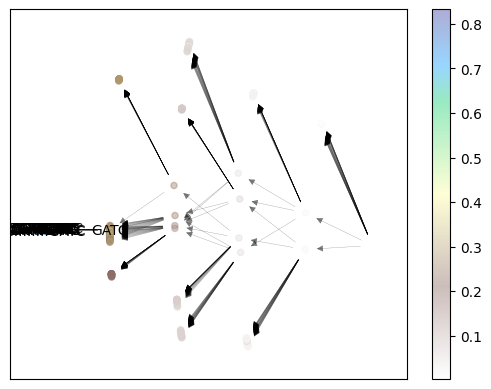

In [301]:
plot_search_graph(search_iter6, label_mean_min = 0.70)

In [302]:
assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mruber = nm.load_pileup("../data/mruber/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_1") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 5) \
    .filter(pl.col("fraction_mod") > 0.85) 

In [317]:
sequence = assembly.assembly["contig_1"]
padding = 15
methylation_index_fwd = mruber \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = mruber \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_iter1 = methylation_sequences_fwd + methylation_sequences_rev

In [318]:
search_iter1 = nm.evaluate.a_star_search("."*padding + "A" + "."*padding, sequence, mruber, methylation_sequences_iter1, min_kl = 0.1, extra_rounds = 2)

DEBUG: ...............A............... | BetaBernoulliModel(alpha=36761, beta=1097465) 
DEBUG: ..............GA............... | BetaBernoulliModel(alpha=24768, beta=289993) 
DEBUG: ..............GA.C............. | BetaBernoulliModel(alpha=17396, beta=89886) 
DEBUG: ...........C..GA............... | BetaBernoulliModel(alpha=15298, beta=100152) 
DEBUG: ...............AT.............. | BetaBernoulliModel(alpha=17791, beta=184441) 
DEBUG: .............CGA............... | BetaBernoulliModel(alpha=14506, beta=91512) 
DEBUG: ..............GATC............. | BetaBernoulliModel(alpha=11447, beta=7973) 
DEBUG: ...........C.CGA............... | BetaBernoulliModel(alpha=11979, beta=28678) 


In [319]:
nxgraph_to_dataframe(search_iter1)

sequence,model,mean
str,object,f64
""".............T…","BetaBernoulliModel(alpha=4101, beta=1116)",0.786084
""".............C…","BetaBernoulliModel(alpha=3696, beta=1245)",0.748027
"""..............…","BetaBernoulliModel(alpha=11447, beta=7973)",0.589444
"""...........CTC…","BetaBernoulliModel(alpha=11128, beta=9680)",0.534794
"""...........C.C…","BetaBernoulliModel(alpha=10708, beta=11038)",0.492412
"""...........C.C…","BetaBernoulliModel(alpha=6087, beta=10354)",0.370233
"""...........C.C…","BetaBernoulliModel(alpha=5266, beta=9567)",0.355019
"""............TC…","BetaBernoulliModel(alpha=11512, beta=22670)",0.336785
"""..........GC.C…","BetaBernoulliModel(alpha=5504, beta=10877)",0.335999


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fc21b4be6d0>


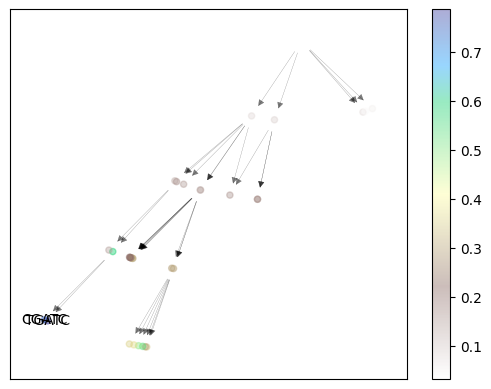

In [320]:
plot_search_graph(search_iter1, label_mean_min = 0.70)

In [324]:
methylation_sequences_iter2 = methylation_sequences_iter1.get_sequences_without_match("." *(padding - 2) + "[CT]GATC" + "." *(padding - 2))
search_iter2 = nm.evaluate.a_star_search("."*padding + "A" + "."*padding, sequence, mruber, methylation_sequences_iter2, min_kl = 0.1, extra_rounds = 2)

DEBUG: ...............A............... | BetaBernoulliModel(alpha=36761, beta=1097465) 
DEBUG: ..............GA............... | BetaBernoulliModel(alpha=24768, beta=289993) 
DEBUG: ..............GA.C............. | BetaBernoulliModel(alpha=17396, beta=89886) 
DEBUG: ...........C..GA............... | BetaBernoulliModel(alpha=15298, beta=100152) 
DEBUG: ...............AT.............. | BetaBernoulliModel(alpha=17791, beta=184441) 
DEBUG: .............CGA............... | BetaBernoulliModel(alpha=14506, beta=91512) 
DEBUG: ..............GATC............. | BetaBernoulliModel(alpha=11447, beta=7973) 
DEBUG: ...........C.CGA............... | BetaBernoulliModel(alpha=11979, beta=28678) 


In [327]:
nxgraph_to_dataframe(search_iter2).get_column("sequence").to_list()

['..............GATCG............',
 '..............GATCA............',
 '..............GATC.............',
 '...........CTCGA...............',
 '...........C.CGAG..............',
 '.............GGATC.............',
 '...........C.CGA.G.............',
 '...........C.CGA.C.............',
 '............TCGA...............',
 '..........GC.CGA...............',
 '.............AGATC.............',
 '..........CC.CGA...............',
 '...........C.CGA...............',
 '...........CT.GA...............',
 '...........C..GAG..............',
 '.............CGAG..............',
 '............G.GA.C.............',
 '.............CGA.C.............',
 '............T.GA.C.............',
 '.............GGA.C.............',
 '...........C..GA.C.............',
 '..........G..CGA...............',
 '...............ATC.............',
 '..............AAT..............',
 '..............GA.C.............',
 '..............GAT..............',
 '..........GC..GA...............',
 '.............CGA.G........

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fc190090370>


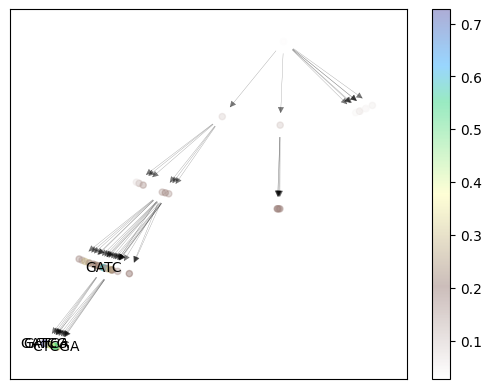

In [326]:
plot_search_graph(search_iter2, label_mean_min = 0.50)

In [328]:
methylation_sequences_iter3 = methylation_sequences_iter2.get_sequences_without_match("." *(padding - 1) + "GATC[AG]" + "." *(padding - 3))
search_iter3 = nm.evaluate.a_star_search("."*padding + "A" + "."*padding, sequence, mruber, methylation_sequences_iter3, min_kl = 0.1, extra_rounds = 2)

DEBUG: ...............A............... | BetaBernoulliModel(alpha=36761, beta=1097465) 
DEBUG: ..............GA............... | BetaBernoulliModel(alpha=24768, beta=289993) 
DEBUG: ..............GA.C............. | BetaBernoulliModel(alpha=17396, beta=89886) 
DEBUG: ...........C..GA............... | BetaBernoulliModel(alpha=15298, beta=100152) 
DEBUG: .............CGA............... | BetaBernoulliModel(alpha=14506, beta=91512) 
DEBUG: ...........C.CGA............... | BetaBernoulliModel(alpha=11979, beta=28678) 
DEBUG: ...........CTCGA............... | BetaBernoulliModel(alpha=11128, beta=9680) 
DEBUG: ...........CT.GA............... | BetaBernoulliModel(alpha=11760, beta=28887) 


In [332]:
nxgraph_to_dataframe(search_iter3).get_column("sequence").to_list()

['...........CTCGAG..............',
 '...........CTCGA.G.............',
 '........G..CTCGA...............',
 '..........GCTCGA...............',
 '...........CTCGA...............',
 '...........CTCGA.C.............',
 '..........CCTCGA...............',
 '...........CT.GAG..............',
 '...........C.CGAG..............',
 '........G..C.CGA...............',
 '...........C.CGA.G.............',
 '........G..CT.GA...............',
 '...........CT.GA.C.............',
 '...........C.CGA.C.............',
 '...........CT.GA.G.............',
 '..........GCT.GA...............',
 '............TCGA...............',
 '..........GC.CGA...............',
 '..........CCT.GA...............',
 '..........CC.CGA...............',
 '...........C.CGA...............',
 '...........CT.GA...............',
 '...........C..GAG..............',
 '.............CGAG..............',
 '............G.GA.C.............',
 '.............CGA.C.............',
 '............T.GA.C.............',
 '.............GGA.C........

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fc1da4b0d30>


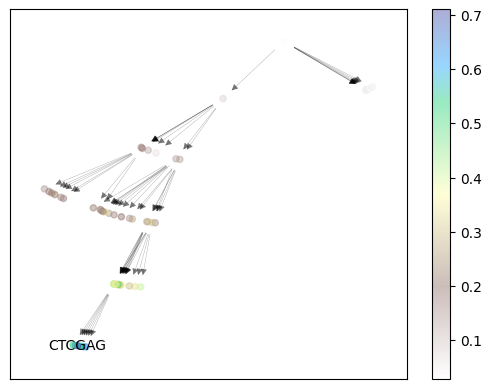

In [333]:
plot_search_graph(search_iter3, label_mean_min = 0.70)

In [334]:
methylation_sequences_iter4 = methylation_sequences_iter3.get_sequences_without_match("." *(padding - 4) + "CTCGAG" + "." *(padding - 1))
search_iter4 = nm.evaluate.a_star_search("."*padding + "A" + "."*padding, sequence, mruber, methylation_sequences_iter4, min_kl = 0.1, extra_rounds = 2)

DEBUG: ...............A............... | BetaBernoulliModel(alpha=36761, beta=1097465) 
DEBUG: ...............AT.............. | BetaBernoulliModel(alpha=17791, beta=184441) 
DEBUG: ............T..A............... | BetaBernoulliModel(alpha=16980, beta=216660) 
DEBUG: ...............A.C............. | BetaBernoulliModel(alpha=20128, beta=379983) 
DEBUG: ..............GA.C............. | BetaBernoulliModel(alpha=17396, beta=89886) 
DEBUG: ............G.GA.C............. | BetaBernoulliModel(alpha=5624, beta=19597) 
DEBUG: ............T..A.C............. | BetaBernoulliModel(alpha=7692, beta=81726) 
DEBUG: ..............GAGC............. | BetaBernoulliModel(alpha=5899, beta=34350) 
DEBUG: ..............AAT.............. | BetaBernoulliModel(alpha=5482, beta=27828) 
DEBUG: ..............AATT............. | BetaBernoulliModel(alpha=4853, beta=1329) 


In [336]:
nxgraph_to_dataframe(search_iter4)

sequence,model,mean
str,object,f64
"""..............…","BetaBernoulliModel(alpha=4853, beta=1329)",0.785021
"""............GG…","BetaBernoulliModel(alpha=2408, beta=1737)",0.580941
"""............G.…","BetaBernoulliModel(alpha=5624, beta=19597)",0.222989
"""............G.…","BetaBernoulliModel(alpha=1753, beta=6490)",0.212665
""".............G…","BetaBernoulliModel(alpha=3917, beta=14911)",0.208041
""".............G…","BetaBernoulliModel(alpha=1775, beta=7084)",0.200361
"""..............…","BetaBernoulliModel(alpha=5482, beta=27828)",0.164575
"""..............…","BetaBernoulliModel(alpha=17396, beta=89886)",0.162152
"""..............…","BetaBernoulliModel(alpha=4992, beta=28318)",0.149865


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fc113da16a0>


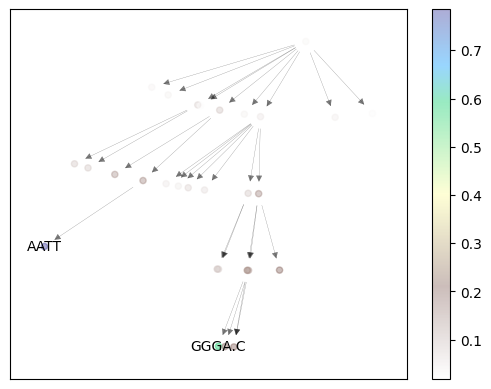

In [335]:
plot_search_graph(search_iter4, label_mean_min = 0.5)

In [337]:
methylation_sequences_iter5 = methylation_sequences_iter4.get_sequences_without_match("." *(padding - 1) + "AATT" + "." *(padding - 2))
search_iter5 = nm.evaluate.a_star_search("."*padding + "A" + "."*padding, sequence, mruber, methylation_sequences_iter5, min_kl = 0.1, extra_rounds = 2)

DEBUG: ...............A............... | BetaBernoulliModel(alpha=36761, beta=1097465) 
DEBUG: ............T..A............... | BetaBernoulliModel(alpha=16980, beta=216660) 
DEBUG: ............TT.A............... | BetaBernoulliModel(alpha=4067, beta=43116) 
DEBUG: ............TTAA............... | BetaBernoulliModel(alpha=3675, beta=965) 


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fc111df6160>


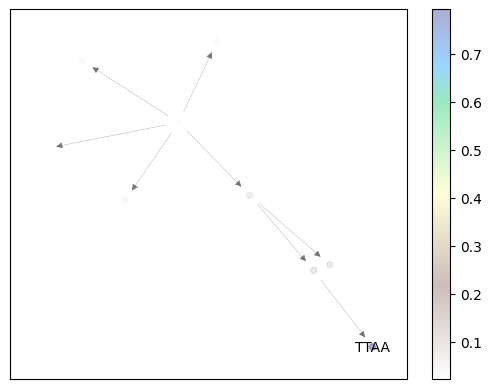

In [338]:
plot_search_graph(search_iter5, label_mean_min = 0.5)

In [339]:
methylation_sequences_iter6 = methylation_sequences_iter5.get_sequences_without_match("." *(padding - 3) + "TTAA" + "." *(padding - 0))
search_iter6 = nm.evaluate.a_star_search("."*padding + "A" + "."*padding, sequence, mruber, methylation_sequences_iter6, min_kl = 0.1, extra_rounds = 2)

DEBUG: ...............A............... | BetaBernoulliModel(alpha=36761, beta=1097465) 
DEBUG: ..............GA............... | BetaBernoulliModel(alpha=24768, beta=289993) 
DEBUG: ..............GA.C............. | BetaBernoulliModel(alpha=17396, beta=89886) 
DEBUG: ..............GAG.............. | BetaBernoulliModel(alpha=12809, beta=90371) 
DEBUG: ...............A.C............. | BetaBernoulliModel(alpha=20128, beta=379983) 
DEBUG: ............G.GA.C............. | BetaBernoulliModel(alpha=5624, beta=19597) 
DEBUG: ..............GAGC............. | BetaBernoulliModel(alpha=5899, beta=34350) 
DEBUG: ............G.GA............... | BetaBernoulliModel(alpha=5907, beta=66532) 
DEBUG: .............GGA.C............. | BetaBernoulliModel(alpha=3917, beta=14911) 
DEBUG: ...............A.C.....G....... | BetaBernoulliModel(alpha=7517, beta=123494) 
DEBUG: ..............GA.C.....G....... | BetaBernoulliModel(alpha=6157, beta=31448) 
DEBUG: ...............AG.............. | BetaBernoulliM

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fbf8990efa0>


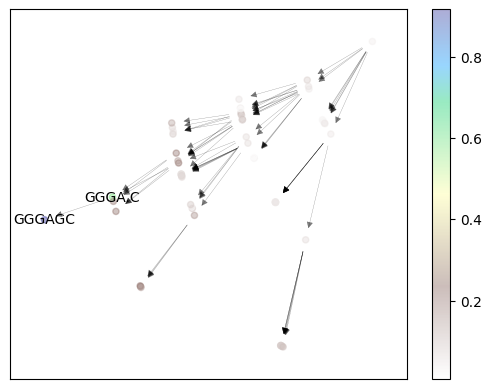

In [340]:
plot_search_graph(search_iter6, label_mean_min = 0.5)

In [341]:
methylation_sequences_iter7 = methylation_sequences_iter6.get_sequences_without_match("." *(padding - 3) + "GGGAGC" + "." *(padding - 2))
search_iter7 = nm.evaluate.a_star_search("."*padding + "A" + "."*padding, sequence, mruber, methylation_sequences_iter7, min_kl = 0.1, extra_rounds = 2)

DEBUG: ...............A............... | BetaBernoulliModel(alpha=36761, beta=1097465) 
DEBUG: .............C.A............... | BetaBernoulliModel(alpha=17136, beta=352848) 
DEBUG: .....G.........A............... | BetaBernoulliModel(alpha=10961, beta=231084) 
DEBUG: .....G.........A.C............. | BetaBernoulliModel(alpha=7001, beta=113482) 
DEBUG: .....G..G......A............... | BetaBernoulliModel(alpha=6487, beta=101896) 
DEBUG: ...............A.......G....... | BetaBernoulliModel(alpha=11277, beta=250570) 
DEBUG: ...............A......TG....... | BetaBernoulliModel(alpha=4705, beta=69237) 
DEBUG: .............C.A.......G....... | BetaBernoulliModel(alpha=5858, beta=108297) 
DEBUG: .............C.A.........C..... | BetaBernoulliModel(alpha=5625, beta=102683) 
DEBUG: .....G..G......A.C............. | BetaBernoulliModel(alpha=3649, beta=44606) 
DEBUG: ...............A......T........ | BetaBernoulliModel(alpha=7419, beta=157295) 
DEBUG: ....GG.........A............... | BetaBernou

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fc090189130>


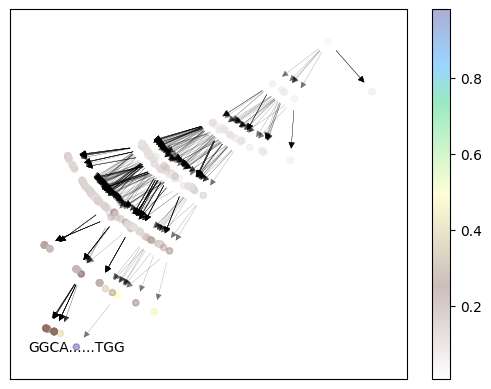

In [342]:
plot_search_graph(search_iter7, label_mean_min = 0.5)

In [343]:
methylation_sequences_iter8 = methylation_sequences_iter7.get_sequences_without_match("." *(padding - 3) + "GGCA......TGG" + "." *(padding - 9))
search_iter8 = nm.evaluate.a_star_search("."*padding + "A" + "."*padding, sequence, mruber, methylation_sequences_iter8, min_kl = 0.1, extra_rounds = 2)

DEBUG: ...............A............... | BetaBernoulliModel(alpha=36761, beta=1097465) 
DEBUG: ...............A.C............. | BetaBernoulliModel(alpha=20128, beta=379983) 
DEBUG: .............C.A............... | BetaBernoulliModel(alpha=17136, beta=352848) 
DEBUG: ........G......A............... | BetaBernoulliModel(alpha=12692, beta=256317) 
DEBUG: ........G....C.A............... | BetaBernoulliModel(alpha=7760, beta=107178) 
DEBUG: .............C.A.C............. | BetaBernoulliModel(alpha=8123, beta=127937) 
DEBUG: ........G......A.C............. | BetaBernoulliModel(alpha=7642, beta=115961) 
DEBUG: ...............A.C.....G....... | BetaBernoulliModel(alpha=7517, beta=123494) 
DEBUG: .....G.........A............... | BetaBernoulliModel(alpha=10961, beta=231084) 
DEBUG: .....G.......C.A............... | BetaBernoulliModel(alpha=7026, beta=111370) 
DEBUG: .....G.........A.C............. | BetaBernoulliModel(alpha=7001, beta=113482) 
DEBUG: .....G..G......A............... | BetaBer

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fc188889e80>


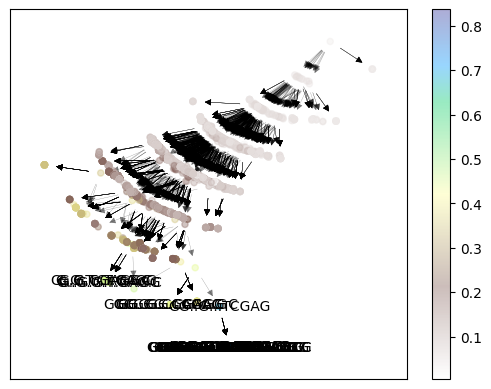

In [344]:
plot_search_graph(search_iter8, label_mean_min = 0.5)